In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
!wget https://s3-us-west-2.amazonaws.com/allennlp/datasets/glove/glove.840B.300d.txt.gz

--2019-04-08 15:58:02--  https://s3-us-west-2.amazonaws.com/allennlp/datasets/glove/glove.840B.300d.txt.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.248.16
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.248.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768669 (2.0G) [text/plain]
Saving to: ‘glove.840B.300d.txt.gz’

glove.840B.300d.txt 100%[===================>]   2.03G  58.6MB/s    in 44s     

2019-04-08 15:58:46 (47.6 MB/s) - ‘glove.840B.300d.txt.gz’ saved [2176768669/2176768669]



In [0]:
!gunzip -k glove.840B.300d.txt.gz

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from nltk.probability import FreqDist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
df = pd.read_csv("train.csv",header = None)

Concatenating the title and the description to form a single column.

In [0]:
concatlist = []
for x in range(df[0].shape[0]):
  concatlist.append(df.loc[x][1] + ' ' + df.loc[x][2])

In [0]:
d = {1:concatlist , 2:df[0]}

In [0]:
data = pd.DataFrame(d)

In [0]:
data.head()

,1,2
0,Wall St. Bears Claw Back Into the Black (Reute...,3
1,Carlyle Looks Toward Commercial Aerospace (Reu...,3
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,3
3,Iraq Halts Oil Exports from Main Southern Pipe...,3
4,"Oil prices soar to all-time record, posing new...",3


#### Make a list of all tokens in the data

In [0]:
all_tokens = [token.lower() for i in data.index for token in data.loc[i, 1].split()]

In [0]:
len(all_tokens)

4541694

#### Compute frequency counts of the tokens

In [0]:
freq = dict(FreqDist(all_tokens))

In [0]:
word_counts = sorted(freq.values(), reverse=True)
print('Total no. of unique tokens:', len(word_counts))

Total no. of unique tokens: 158733


#### Tokenize the data and make sequences containing the word ids

In [0]:
NUM_WORDS = 150000
tokenizer = Tokenizer(num_words=NUM_WORDS, filters='')
tokenizer.fit_on_texts(data[1])
sequences = tokenizer.texts_to_sequences(data[1])
word_index = tokenizer.word_index

#### Some statistics of the sequence length

In [0]:
lengths = np.asarray([len(s) for s in sequences])
print('Mean length of sequence:', np.mean(lengths))
print('Std. Dev. of length:', np.std(lengths))
MAX_LEN = 100
print('Percentage of sequences with length less than MAX_LEN:',\
      np.mean(lengths<MAX_LEN)*100)

Mean length of sequence: 34.354191666666665
Std. Dev. of length: 9.414208584010867
Percentage of sequences with length less than MAX_LEN: 99.93583333333333


#### Pad the sequences upto MAX_LEN length and one-hot encode labels

In [0]:
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Encode to string valued labels into integers
LE = LabelEncoder()
LE.fit(data[2])

# Convert the integer labels to one-hot
labels = to_categorical(LE.transform(data[2]))

print('X.shape = %s \t labels.shape = %s'%(str(X.shape), str(labels.shape)))

X.shape = (120000, 100) 	 labels.shape = (120000, 4)


#### Do a train-test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=5000)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_yest:', y_test.shape)

Shape of X_train: (115000, 100)
Shape of X_test: (5000, 100)
Shape of y_train: (115000, 4)
Shape of y_yest: (5000, 4)


#### Load GloVe word embeddings

In [0]:
embeddings = {}
EMBEDDING_DIM = 300
with open('glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        line = line.split(' ')
        word = line[0]
        vector = np.asarray(line[1:], dtype='float32')
        assert len(vector) == EMBEDDING_DIM
        embeddings[word] = vector
print('Size of vocab: %d'%len(embeddings))

Size of vocab: 2196016


#### Using the embedding dictionary to compute the embedding matrix

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    vector = embeddings.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
del embeddings # Free some memory

NameError: ignored

#### Initialize the embedding layer

In [0]:
embedding_layer = Embedding(len(word_index) + 1,\
                            EMBEDDING_DIM,\
                            weights=[embedding_matrix],\
                            input_length=MAX_LEN,\
                            trainable=False)

In [0]:
cp = ModelCheckpoint('model_cnn.hdf5', monitor='val_loss',\
                     verbose=1, save_best_only=True)

#### Build the model - 3 Conv layers with dropout in between + 2 Dense layers

In [0]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

opt = Adam(1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          47620200  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
dropout_4 (Dropout)          (None, 96, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 92, 128)           82048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 92, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 88, 128)           82048     
_________________________________________________________________
dropout_6 (Dropout)          (None, 88, 128)           0         
__________

#### Train the model

In [0]:
# Weighted cross-entropy loss to handle class imbalance
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=20, batch_size=32, callbacks=[cp],\
                    class_weight='auto') 

Instructions for updating:
Use tf.cast instead.
Train on 115000 samples, validate on 5000 samples
Epoch 1/20
115000/115000 [==============================] - 51s 445us/step - loss: 0.3781 - acc: 0.8676 - val_loss: 0.2978 - val_acc: 0.8934

Epoch 00001: val_loss improved from inf to 0.29782, saving model to model_cnn.hdf5
Epoch 2/20
115000/115000 [==============================] - 46s 402us/step - loss: 0.3104 - acc: 0.8935 - val_loss: 0.2925 - val_acc: 0.9010

Epoch 00002: val_loss improved from 0.29782 to 0.29253, saving model to model_cnn.hdf5
Epoch 3/20
115000/115000 [==============================] - 46s 397us/step - loss: 0.2877 - acc: 0.9009 - val_loss: 0.2942 - val_acc: 0.8976

Epoch 00003: val_loss did not improve from 0.29253
Epoch 4/20
115000/115000 [==============================] - 46s 396us/step - loss: 0.2741 - acc: 0.9052 - val_loss: 0.2703 - val_acc: 0.9092

Epoch 00004: val_loss improved from 0.29253 to 0.27028, saving model to model_cnn.hdf5
Epoch 5/20
115000/115000 [

#### Plot the loss and accuracy w.r.t. the no. of epochs

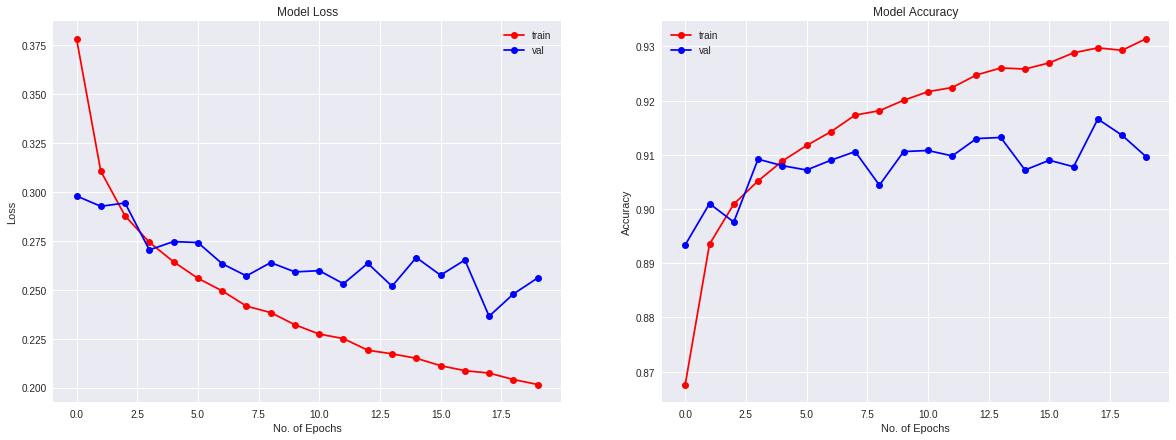

In [0]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'ro-', label='train')
plt.plot(history.history['val_loss'], 'bo-', label='val')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], 'ro-',label='train')
plt.plot(history.history['val_acc'], 'bo-', label='val')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

#### Predict and compute the F1 Score on the validation set 

In [0]:
model.load_weights('model_cnn.hdf5')
probs = model.predict(X_test)
y_pred = np.zeros(probs.shape)
y_pred[range(y_pred.shape[0]), np.argmax(probs, axis=1)] = 1

In [0]:
print('Validation F1 Score:', f1_score(y_test, y_pred, average='weighted'))

Validation F1 Score: 0.9167701139908581


In [0]:
testdata = pd.read_csv('test.csv', header = None)

### Predict on the test set

#### Read test data

In [0]:
concatlist = []
for x in range(testdata[0].shape[0]):
  concatlist.append(testdata.loc[x][1] + ' ' + testdata.loc[x][2])

d = {1:concatlist}
testdata = pd.DataFrame(d)

In [0]:
testdata.head()

,1
0,Fears for T N pension after talks Unions repre...
1,The Race is On: Second Private Team Sets Launc...
2,Ky. Company Wins Grant to Study Peptides (AP) ...
3,Prediction Unit Helps Forecast Wildfires (AP) ...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


#### Tokenize and pad test sequences

In [0]:
test_sequences = tokenizer.texts_to_sequences(testdata[1])
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)

#### Make predictions

In [0]:
test_prob = model.predict(test_padded)
test_prob[:5]

array([[3.6549038e-01, 8.4645618e-03, 5.7449776e-01, 5.1547296e-02],
       [3.9576785e-06, 8.7964245e-12, 3.0804949e-04, 9.9968803e-01],
       [1.9092502e-02, 6.4570463e-04, 4.2273581e-02, 9.3798816e-01],
       [1.7039423e-01, 7.2223279e-03, 3.2802097e-02, 7.8958130e-01],
       [9.0451546e-02, 3.0638666e-03, 9.8807372e-02, 8.0767727e-01]],
      dtype=float32)

#### Convert probablities into integer labels

In [0]:
test_pred = np.argmax(test_prob, axis=1)
test_pred[:5]

array([2, 3, 3, 3, 3])

#### Convert the integer lables into the corresponding string targets

In [0]:
test_classes = LE.inverse_transform(test_pred)
test_classes[:5]

array([3, 4, 4, 4, 4])

In [0]:
label_to_string = {1:'World' ,2:'Sports', 3:'Business', 4:'Sci/Tech'}
test_labels = [label_to_string[x] for x in test_classes]

#### Make submission dataframe

In [0]:
submit = testdata.copy()
submit[2] = test_labels
submit.columns = ['Title + description', 'predicted_category']
submit.head()

,Title + description,predicted_category
0,Fears for T N pension after talks Unions repre...,Business
1,The Race is On: Second Private Team Sets Launc...,Sci/Tech
2,Ky. Company Wins Grant to Study Peptides (AP) ...,Sci/Tech
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,Sci/Tech


#### Write to submission.csv

In [0]:
submit.to_csv('submission.csv', index=None)

In [0]:
!ls

glove.840B.300d.txt	model_cnn.hdf5	submission.csv	train.csv
glove.840B.300d.txt.gz	sample_data	test.csv


In [0]:
files.download('submission.csv') 